In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import copy
import torch
from skimage.transform import rescale, resize
from utils import FaceDataset

data = FaceDataset("data")

In [8]:
train_size = int(0.9*len(data))
train_data, test_data = random_split(data, [train_size, len(data)-train_size])

In [9]:
train_data_loader = DataLoader(dataset= train_data,batch_size=10, shuffle=True)
test_data_loader = DataLoader(dataset=test_data, batch_size=10, shuffle=True)

In [10]:
example, name = next(iter(train_data_loader))

TypeError: new() received an invalid combination of arguments - got (list, dtype=torch.tensortype), but expected one of:
 * (*, torch.device device)
      didn't match because some of the keywords were incorrect: dtype
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)


In [30]:
name[0]

'easy'

In [9]:
example.shape

torch.Size([10, 600, 600])

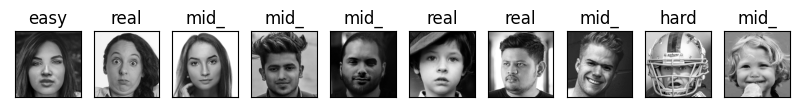

In [10]:
plt.figure(figsize=(10, 10))
for ib in range(10):
    plt.subplot(1, 10, ib+1)
    im = example[ib, :]
    plt.imshow(im, cmap="gray")#, interpolation='lanczos')
    plt.title(name[ib])
    plt.xticks([]), plt.yticks([])
plt.show()

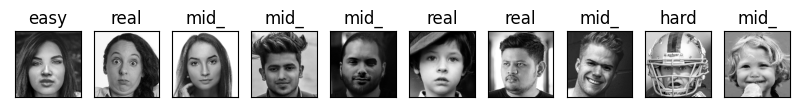

In [11]:
plt.figure(figsize=(10, 10))
for ib in range(10):
    plt.subplot(1, 10, ib+1)
    im = rescale(example[ib, :], 0.25, anti_aliasing=False)
    plt.imshow(im, cmap="gray")#, interpolation='lanczos')
    plt.title(name[ib])
    plt.xticks([]), plt.yticks([])
plt.show()

In [15]:
class MLPClassif(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, act_fn):
        super(MLPClassif, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, hidden_size)
        self.out_layer = nn.Linear(hidden_size, 1)
        self.act_fn = act_fn
    
    def forward(self, x):
        
        # TO DO: write the 'forward' method, which computes the output 'out' from the input x
        # It should apply sequentially the input, hidden, and output layer, as we did in the example before.
        #x = x.view(-1, 784)
        x = self.act_fn(self.hidden1(x))
        x = self.act_fn(self.hidden2(x))
        x = self.act_fn(self.out_layer(x))
        out = nn.Sigmoid(x)
        return out

In [16]:
model = MLPClassif(600*600, 50, 2, nn.ReLU())

In [17]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)

torch.manual_seed(0)
model.apply(init_weights)

MLPClassif(
  (hidden1): Linear(in_features=360000, out_features=50, bias=True)
  (hidden2): Linear(in_features=50, out_features=50, bias=True)
  (out_layer): Linear(in_features=50, out_features=1, bias=True)
  (act_fn): ReLU()
)

In [20]:
def training_mlp_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    
    # Define the optimizer
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            labels = torch.Tensor([(l=="real") for l in labels])
            
            # TO DO: write the training procedure for each batch. This should consist of:
            # - vectorizing the images (size should be (batch_size, input_size))
            # - apply the forward pass (calculate the predicted labels from the vectorized images)
            # - use the 'backward' method to compute the gradients
            # - apply the gradient descent algorithm
            # Also think of updating the loss at the current epoch
            images = images.view(-1, 600*600).type(torch.float)
            y_pred = model_tr(images)
            l = loss_fn(y_pred, labels.long())
            optimizer.zero_grad()
            l.backward()
            loss_current_epoch += l.item()
            optimizer.step() #update parameters

        # At the end of each epoch, record and display the loss over all batches
        loss_all_epochs.append(loss_current_epoch)
        if verbose:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))
        
    return model_tr, loss_all_epochs

In [21]:
num_epochs = 10
learning_rate = 0.01
loss_fn = nn.BCELoss()
model_trained, history = training_mlp_classifier(model, train_data_loader, num_epochs,
loss_fn , learning_rate, verbose=True)

TypeError: Module.__init__() takes 1 positional argument but 2 were given

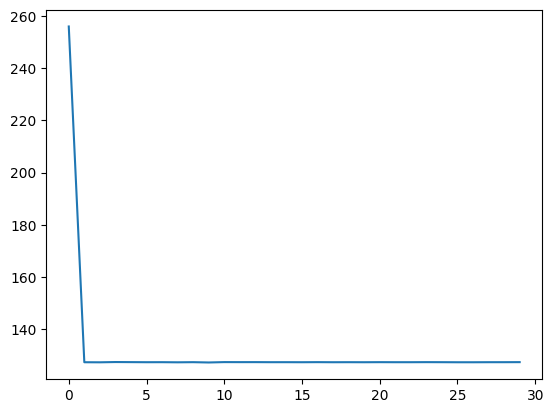

In [68]:
plt.plot(range(30), history)

In [71]:
def eval_mlp_classifier(model, eval_dataloader):
    
    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval() 

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0
        
        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:
            labels = torch.Tensor([(l=="real") for l in labels])
            # Get the predicted labels
            images = images.reshape(images.shape[0], -1).type(torch.float)
            y_predicted = model(images)
            
            # To get the predicted labels, we need to get the max over all possible classes
            _, label_predicted = torch.max(y_predicted.data, 1)
            
            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct_labels / total_labels
    
    return accuracy

In [72]:
eval_mlp_classifier(model_trained, test_data_loader)

55.609756097560975